In [1]:
# Set the working directory to the parent directory
import sys
sys.path.append('..')
sys.dont_write_bytecode = True

# Import relevant packages
from src.eda import data_info, VisualDistr, VisualCorr
import pandas as pd
import warnings
import numpy as np
from IPython.display import display

# Config
pd.set_option('display.max_columns', None) # Ensure all columns are displayed
warnings.filterwarnings("ignore")

In [2]:
# Read the raw data
raw_data = pd.read_csv("../data/raw/raw.csv", sep=";")
raw_data.columns = [col.replace(".", "_") for col in raw_data.columns]

# There are several missing values in some categorical attributes, all coded with the "unknown" label
# Replace all "unknown" values as np.nan to detect missing values
raw_data = raw_data.replace("unknown", np.nan)
# Replace '999' value of pdays to np.nan
raw_data['pdays'] = raw_data['pdays'].replace(999, np.nan)

# Save the unprocessed data (partially cleaned raw data)
raw_data.to_feather("../data/raw/unprocessed.feather")

## 1. Data Description

In [3]:
# Structure of the data
print(f"Rows: {raw_data.shape[0]}")
print(f"Columns: {raw_data.shape[1]}")

# Get the detection results
var_info = data_info(raw_data)
display(var_info)
display(var_info["var_type"].value_counts())
num_vars = var_info[var_info['var_type']=='numerical']['var_name']
cat_vars = var_info[var_info['var_type'].isin(['binary', 'categorical'])]['var_name']

# Save the data description
var_info.to_csv("../results/preprocessing/raw_data_description.csv", index=False)

Rows: 41188
Columns: 21


,var_name,var_type,data_type,missing,mean,median,mode,std_dev,skewness,kurtosis,min,max,num_unique,unique_list
0,age,numerical,int64,0,40.024060,38.000,NaN,10.421250,0.784697,0.791312,17.000,98.000,NaN,NaN
1,job,categorical,object,330,NaN,NaN,admin.,NaN,NaN,NaN,NaN,NaN,11.0,"[housemaid, services, admin., blue-collar, tec..."
2,marital,categorical,object,80,NaN,NaN,married,NaN,NaN,NaN,NaN,NaN,3.0,"[married, single, divorced, nan]"
3,education,categorical,object,1731,NaN,NaN,university.degree,NaN,NaN,NaN,NaN,NaN,7.0,"[basic.4y, high.school, basic.6y, basic.9y, pr..."
4,default,binary,object,8597,NaN,NaN,no,NaN,NaN,NaN,NaN,NaN,2.0,"[no, nan, yes]"
5,housing,binary,object,990,NaN,NaN,yes,NaN,NaN,NaN,NaN,NaN,2.0,"[no, yes, nan]"
6,loan,binary,object,990,NaN,NaN,no,NaN,NaN,NaN,NaN,NaN,2.0,"[no, yes, nan]"
7,contact,categorical,object,0,NaN,NaN,cellular,NaN,NaN,NaN,NaN,NaN,2.0,"[telephone, cellular]"
8,month,categorical,object,0,NaN,NaN,may,NaN,NaN,NaN,NaN,NaN,10.0,"[may, jun, jul, aug, oct, nov, dec, mar, apr, ..."
9,day_of_week,categorical,object,0,NaN,NaN,thu,NaN,NaN,NaN,NaN,NaN,5.0,"[mon, tue, wed, thu, fri]"


var_type
numerical      10
categorical     7
binary          4
Name: count, dtype: int64

In [4]:
latex_template = r"""
\begin{table}[!t]
    \centering
    \caption{Summary statistics and metadata for selected input variables}
    \label{tab:raw-data-description}
    \begin{tabular}{llllrrrrrrr}
    \toprule
    \textbf{Variable} & \textbf{Definition} & \textbf{Type} & \textbf{Data Type} & \textbf{Missing} & \textbf{Mean} & \textbf{Median} & \textbf{Mode} & \textbf{Std. Dev.} & \textbf{Min} & \textbf{Max} & \textbf{\# Unique} \\
    \midrule
%s
    \bottomrule
    \end{tabular}
    \vspace{2mm}
    \caption*{\footnotesize Variable-level metadata and descriptive statistics computed on the raw dataset. For categorical variables, summary statistics such as mean, median, and standard deviation are omitted. The number of unique values and the mode are reported instead.}
\end{table}
"""

attributes = pd.read_csv("../data/raw/attributes.txt", sep="\t")
var_info_def = var_info.merge(attributes, left_on='var_name', right_on='variable', how='left')

def format_value(v):
    if pd.isna(v):
        return "--"
    if isinstance(v, float):
        return f"{v:.3f}"
    return str(v)

rows = []
for _, row in var_info_def.iterrows():
    var = '\\texttt{' + row['var_name'].replace("_", "\\_") + '}'
    var_type = row['var_type']
    dtype = '\\texttt{' + str(row['data_type']) + '}'
    missing = row['missing']
    mean = row['mean']
    median = row['median']
    mode = row['mode'] if var_type in ['binary', 'categorical'] else f"{row['mode']:.3f}"
    std = row['std_dev']
    minv = row['min']
    maxv = row['max']
    nunique = row['num_unique']
    definition = row['definition'] if pd.notna(row['definition']) else ""

    latex_row = f"{var} & {definition} & {var_type} & {dtype} & {missing} & {mean:.3f} & {median:.3f} & {mode} & {std:.3f} & {minv:.3f} & {maxv:.3f} & {nunique:.0f} \\\\".replace(" nan ", " -- ")
    rows.append(latex_row)

latex_table = latex_template % "\n".join(rows)
print(latex_table)


\begin{table}[!t]
    \centering
    \caption{Summary statistics and metadata for selected input variables}
    \label{tab:raw-data-description}
    \begin{tabular}{llllrrrrrrr}
    \toprule
    \textbf{Variable} & \textbf{Definition} & \textbf{Type} & \textbf{Data Type} & \textbf{Missing} & \textbf{Mean} & \textbf{Median} & \textbf{Mode} & \textbf{Std. Dev.} & \textbf{Min} & \textbf{Max} & \textbf{\# Unique} \\
    \midrule
\texttt{age} & Age of the client (in years) & numerical & \texttt{int64} & 0 & 40.024 & 38.000 & -- & 10.421 & 17.000 & 98.000 & -- \\
\texttt{job} & Client’s employment type or occupational category & categorical & \texttt{object} & 330 & -- & -- & admin. & -- & -- & -- & 11 \\
\texttt{marital} & Client’s marital status & categorical & \texttt{object} & 80 & -- & -- & married & -- & -- & -- & 3 \\
\texttt{education} & Client’s highest level of education attained & categorical & \texttt{object} & 1731 & -- & -- & university.degree & -- & -- & -- & 7 \\
\texttt{def

## 2. Data Distribution

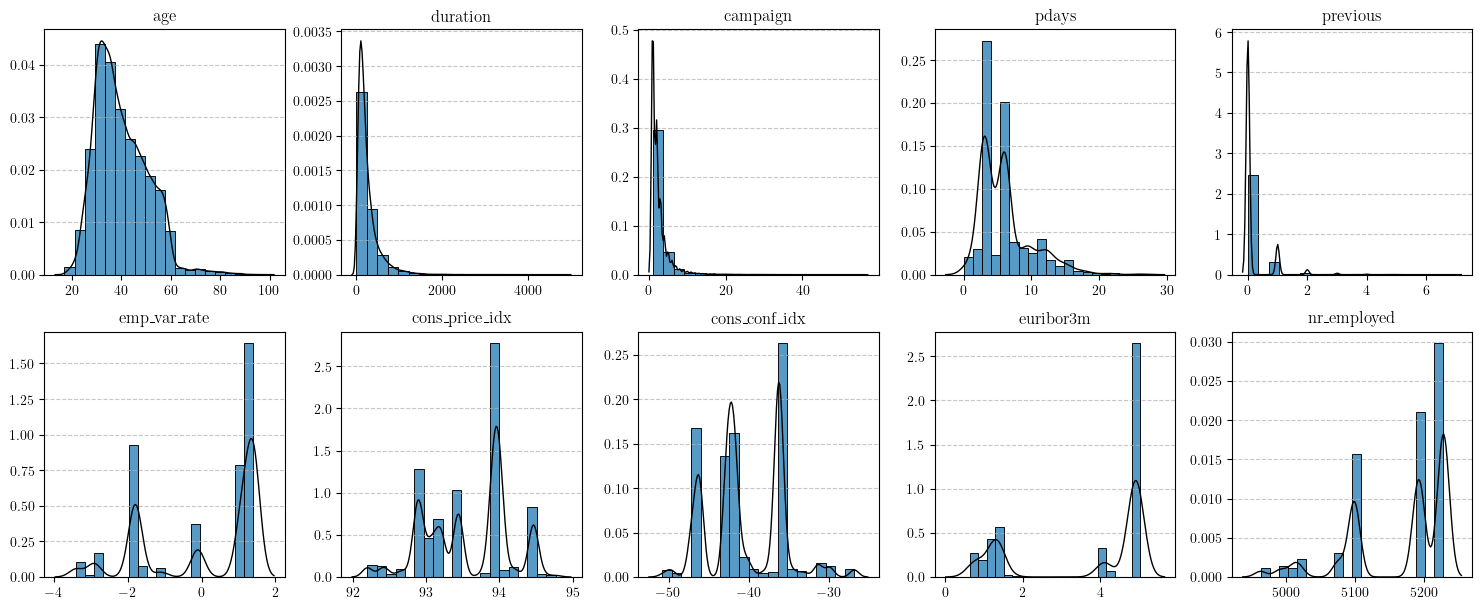

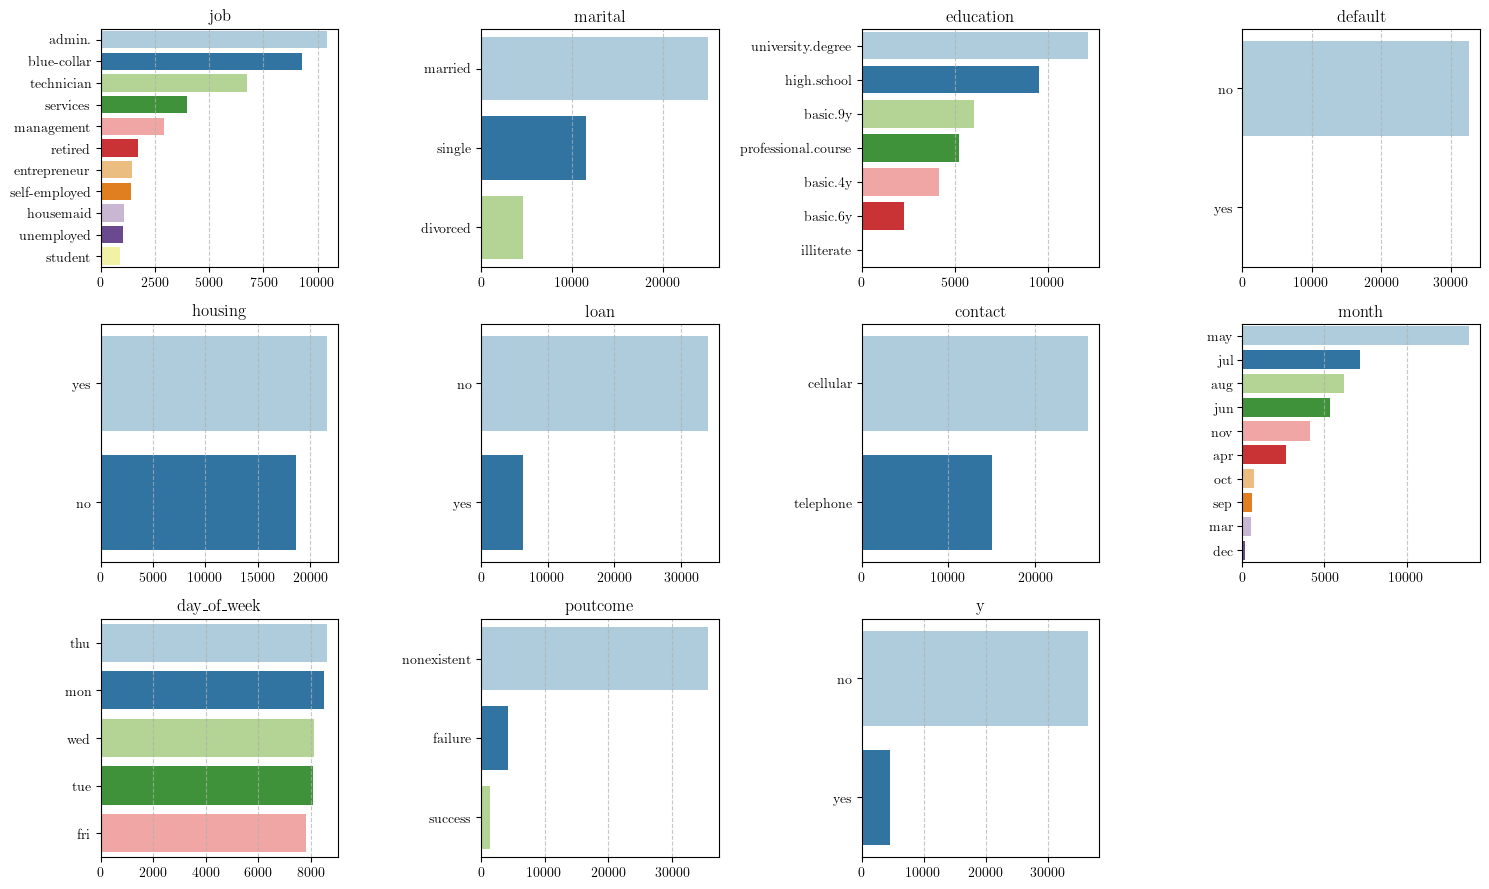

count       pct
var_name    value                               
job         admin.               10422  0.255079
            blue-collar           9254  0.226492
            technician            6743  0.165035
            services              3969  0.097141
            management            2924  0.071565
            retired               1720  0.042097
            entrepreneur          1456  0.035636
            self-employed         1421  0.034779
            housemaid             1060  0.025944
            unemployed            1014  0.024818
            student                875  0.021416
marital     married              24928  0.606403
            single               11568  0.281405
            divorced              4612  0.112192
education   university.degree    12168  0.308386
            high.school           9515  0.241149
            basic.9y              6045  0.153205
            professional.course   5243  0.132879
            basic.4y              4176  0.105837
            basic.6y              2292  0.058089
            illiterate              18  0.000456
default     no                   32588  0.999908
            yes                      3  0.000092
housing     yes                  21576  0.536743
            no                   18622  0.463257
loan        no                   33950  0.844569
            yes                   6248  0.155431
contact     cellular             26144  0.634748
            telephone            15044  0.365252
month       may                  13769  0.334296
            jul                   7174  0.174177
            aug                   6178  0.149995
            jun                   5318  0.129115
            nov                   4101  0.099568
            apr                   2632  0.063902
            oct                    718  0.017432
            sep                    570  0.013839
            mar                    546  0.013256
            dec                    182  0.004419
day_of_week thu                   8623  0.209357
            mon                   8514  0.206711
            wed                   8134  0.197485
            tue                   8090  0.196416
            fri                   7827  0.190031
poutcome    nonexistent          35563  0.863431
            failure               4252  0.103234
            success               1373  0.033335
y           no                   36548  0.887346
            yes                   4640  0.112654

In [5]:
vd = VisualDistr(raw_data, cat_vars, num_vars)

# Plot the distributions of numerical variables
plt_num_distr = vd.plot_numerical_distributions(bins=20)
plt_num_distr.savefig("../results/figures/raw_num_distr.png")
plt_num_distr.show()

# Plot the distributions of categorical variables
plt_cat_distr = vd.plot_categorical_distributions(num_cols=4)
plt_cat_distr.savefig("../results/figures/raw_cat_distr.png")
plt_cat_distr.show()

# Compute the distributions of categorical variables
categorical_distributions = vd.compute_categorical_distributions()
display(categorical_distributions.set_index(["var_name", "value"]))

## 3. Correlations among variables

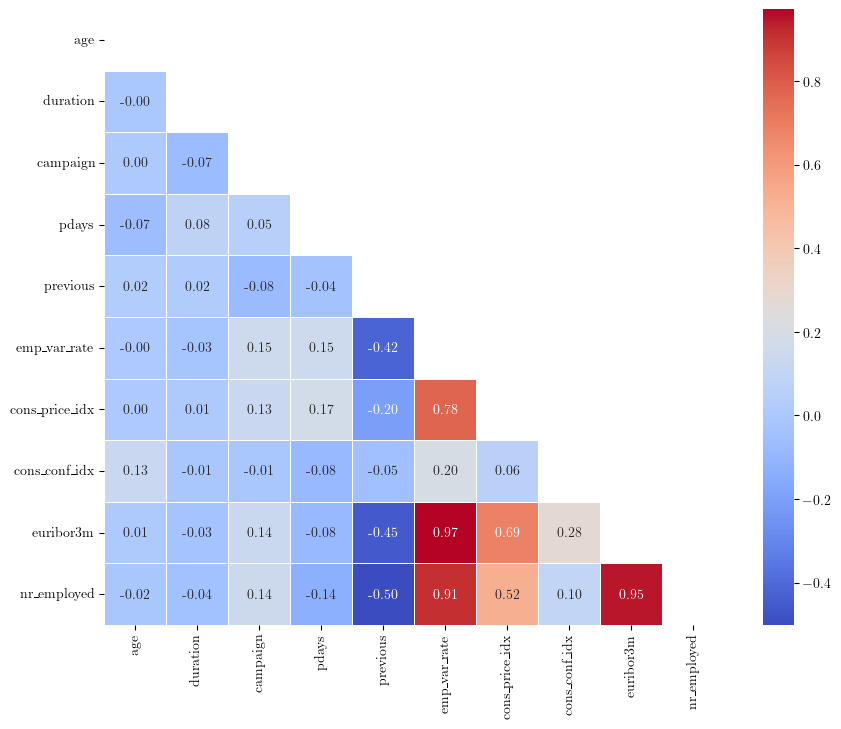

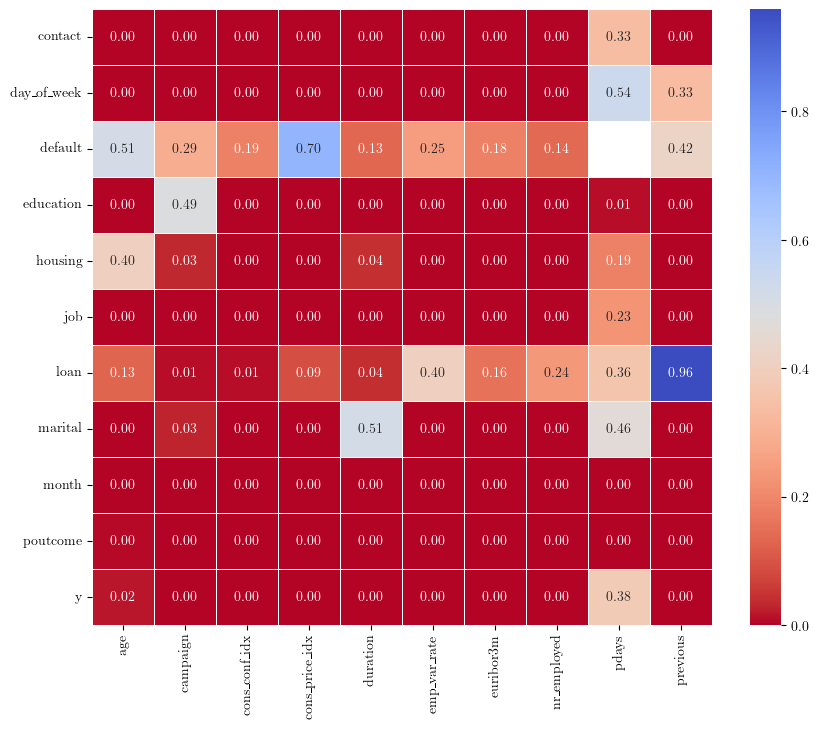

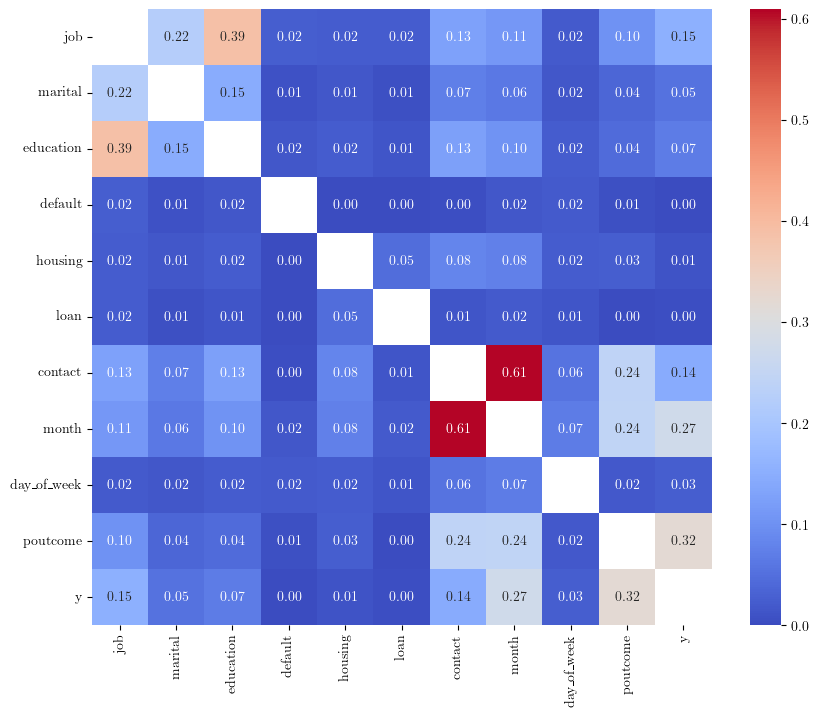

In [6]:
vc = VisualCorr(raw_data, cat_vars, num_vars)

# Plot the correlations between numerical variables
plt_num_num_corr = vc.num_num_corr()
plt_num_num_corr.savefig("../results/figures/raw_num_num_corr.png")
plt_num_num_corr.show()

# Plot the correlations between categorical vs. numerical variables
plt_cat_num_corr = vc.cat_num_corr()
plt_cat_num_corr.savefig("../results/figures/raw_cat_num_corr.png")
plt_cat_num_corr.show()

# Plot the correlations between categorical variables
plt_cat_cat_corr = vc.cat_cat_corr()
plt_cat_cat_corr.savefig("../results/figures/raw_cat_cat_corr.png")
plt_cat_cat_corr.show()